In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import Tensorflow & Keras
from tensorflow import keras
from keras.models import Model
from keras.layers import *
from keras.regularizers import l2
from keras.applications.resnet50 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
#from keras.applications import VGG19,Resnet
from tensorflow.keras.applications import VGG19
pre_trained_model = tf.keras.applications.VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")
import cv2
import os
import random
import tensorflow as tf

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
data_dir = "/content/drive/MyDrive/flowers/flowers"

# Data preprocessing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


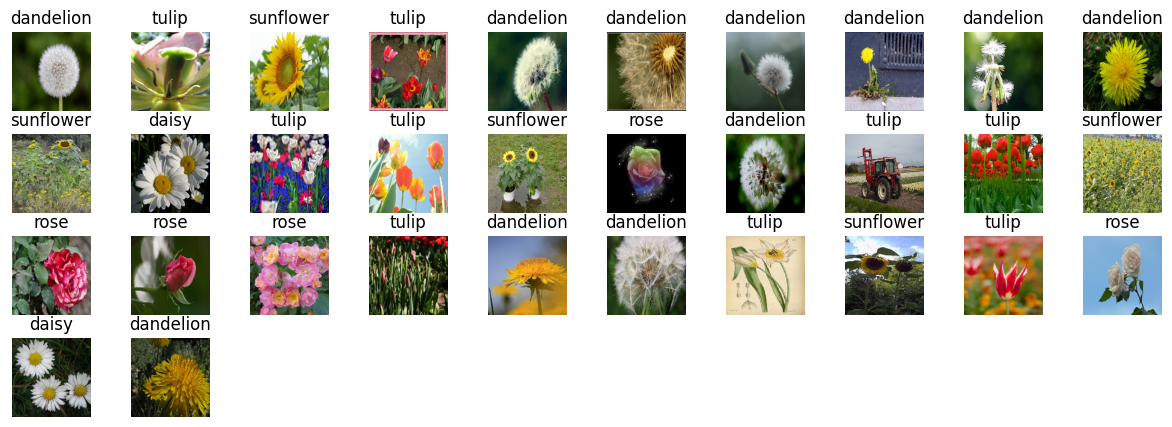

In [ ]:
# Assuming you have a generator like train_generator
train_images, train_labels = train_generator.next()

# Assuming you have a dictionary with class labels
class_labels = {0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}

# Visualizing training samples
plt.figure(figsize=(15, 5))
batch_size = train_images.shape[0]  # Get the actual batch size

for i in range(batch_size):
    plt.subplot(4, 10, i + 1)
    plt.imshow(train_images[i], cmap=plt.cm.hsv)

    # Assuming train_labels is one-hot encoded
    label_index = np.argmax(train_labels[i])
    class_label = class_labels[label_index]

    plt.title(class_label)
    plt.axis('off')

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [ ]:
# Normalize pixel values to be between 0 and 1
train_images, train_labels = train_generator.next()
train_images = train_images.astype('float32') / 255.0

validation_images, validation_labels = validation_generator.next()
validation_images = validation_images.astype('float32') / 255.0

In [ ]:
# Assuming you have a test generator
test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # To keep the order of predictions
)

# One-hot encoded labels are directly accessible from the generator
train_labels = train_generator.classes
test_labels = test_generator.classes

Found 4317 images belonging to 5 classes.


In [ ]:
# One-hot encoded labels are directly accessible from the generator
train_labels = train_generator.classes
test_labels = test_generator.classes

In [ ]:
# Convert integer labels to one-hot encoding
train_labels = to_categorical(train_generator.classes)
test_labels = to_categorical(test_generator.classes)

In [ ]:
def squeeze_excite_block(input, ratio=16):

    init = input
    filters = init._keras_shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)
    x = multiply([init, se])

    return x

In [ ]:
def create_se_resnet(img_input, include_top, initial_conv_filters, filters,
                      depth, width, weight_decay, pooling, ratio=16):

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    N = list(depth)

    x = Conv2D(initial_conv_filters, (7, 7), padding='same', use_bias=False, strides=(2, 2),
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(img_input)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    for i in range(N[0]):
        x = se_resnet_block(x, filters[0], width, ratio=ratio)

    for k in range(1, len(N)):
        x = se_resnet_block(x, filters[k], width, strides=(2, 2), ratio=ratio)

    for i in range(N[k] - 1):
        x = se_resnet_block(x, filters[k], width, ratio=ratio)

    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)

    if include_top:
        x = Dense(NUM_CLASSES, use_bias=False, kernel_regularizer=l2(weight_decay),
                  activation='softmax')(x)

    return x

# Assuming you have the necessary parameters
NUM_CLASSES = 5  # Replace 5 with the actual number of classes in your problem
img_input = Input(shape=(224, 224, 3))
output = create_se_resnet(img_input=img_input, include_top=True, initial_conv_filters=64,
                           filters=[64, 128, 256, 512], depth=[3, 4, 6, 3], width=1, weight_decay=1e-4, pooling=None)
model = Model(inputs=img_input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_66 (Conv2D)          (None, 112, 112, 64)         9408      ['input_6[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 56, 56, 64)           0         ['conv2d_66[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_67 (Conv2D)          (None, 56, 56, 64)           4096      ['max_pooling2d_2[0][0]'] 

In [ ]:
# Assuming you have the necessary parameters
NUM_CLASSES = 5 # Replace ... with the actual number of classes in your problem
img_input = Input(shape=(224, 224, 3))

from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Reshape, Multiply
from keras.models import Model
from keras.regularizers import l2
import keras.backend as K

def squeeze_excite_block(input_tensor, ratio=16):
    channels = K.int_shape(input_tensor)[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, channels))(se)
    se = Dense(channels // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = Multiply()([input_tensor, se])
    return x

def se_resnet_block(input_tensor, filters, width, strides=(1, 1), ratio=16):
    x = Conv2D(filters, (1, 1), strides=strides, padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters * width, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)

    x = squeeze_excite_block(x, ratio)

    shortcut = Conv2D(filters * width, (1, 1), strides=strides, padding='same', use_bias=False,
                      kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    x = keras.layers.add([x, shortcut])
    return x

def create_se_resnet(img_input, include_top, initial_conv_filters, filters,
                      depth, width, weight_decay, pooling, ratio=16):

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    N = list(depth)

    x = Conv2D(initial_conv_filters, (7, 7), padding='same', use_bias=False, strides=(2, 2),
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(img_input)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    for i in range(N[0]):
        x = se_resnet_block(x, filters[0], width, ratio=ratio)

    for k in range(1, len(N)):
        x = se_resnet_block(x, filters[k], width, strides=(2, 2), ratio=ratio)

    for i in range(N[k] - 1):
        x = se_resnet_block(x, filters[k], width, ratio=ratio)

    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)

    if include_top:
        x = Dense(NUM_CLASSES, use_bias=False, kernel_regularizer=l2(weight_decay),
                  activation='softmax')(x)

    return x

# Assuming you have the necessary parameters
img_input = Input(shape=(224, 224, 3))
output = create_se_resnet(img_input=img_input, include_top=True, initial_conv_filters=64,
                           filters=[64, 128, 256, 512], depth=[3, 4, 6, 3], width=1, weight_decay=1e-4, pooling=None)
model = Model(inputs=img_input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
# Split the data into training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Use the training subset
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use the validation subset
)

# Train the model using fit with validation data
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.
Epoch 1/10
108/108 [==============================] - 850s 8s/step - loss: 2.9078 - accuracy: 0.4432 - val_loss: nan - val_accuracy: 0.1743
Epoch 2/10
108/108 [==============================] - 19s 172ms/step - loss: 2.5079 - accuracy: 0.5688 - val_loss: nan - val_accuracy: 0.1755
Epoch 3/10
108/108 [==============================] - 17s 159ms/step - loss: 2.2987 - accuracy: 0.6409 - val_loss: nan - val_accuracy: 0.1779
Epoch 4/10
108/108 [==============================] - 17s 160ms/step - loss: 2.1508 - accuracy: 0.6876 - val_loss: nan - val_accuracy: 0.1779
Epoch 5/10
108/108 [==============================] - 16s 145ms/step - loss: 1.9616 - accuracy: 0.7492 - val_loss: nan - val_accuracy: 0.1779
Epoch 6/10
108/108 [==============================] - 16s 144ms/step - loss: 1.8021 - accuracy: 0.7851 - val_loss: nan - val_accuracy: 0.1755
Epoch 7/10
108/108 [==============================] - 16s 147ms/ste

In [ ]:
# Generate predictions on the training set
train_predictions = model.predict(train_generator)

# Convert one-hot encoded labels to integers for the training set
y_train_true = train_generator.classes

# Convert predicted probabilities to class labels for the training set
y_train_pred_labels = np.argmax(train_predictions, axis=1)

# Get the classification report and confusion matrix for the training set
from sklearn.metrics import classification_report, confusion_matrix
print("Training Classification Report:")
print(classification_report(y_train_true, y_train_pred_labels))

# Optionally, print the confusion matrix for the training set
print("Training Confusion Matrix:")
print(confusion_matrix(y_train_true, y_train_pred_labels))

109/109 [==============================] - 12s 110ms/step
Training Classification Report:
              precision    recall  f1-score   support

           0       0.18      1.00      0.30       612
           1       0.00      0.00      0.00       842
           2       0.00      0.00      0.00       628
           3       0.00      0.00      0.00       587
           4       0.00      0.00      0.00       788

    accuracy                           0.18      3457
   macro avg       0.04      0.20      0.06      3457
weighted avg       0.03      0.18      0.05      3457

Training Confusion Matrix:
[[612   0   0   0   0]
 [842   0   0   0   0]
 [628   0   0   0   0]
 [587   0   0   0   0]
 [788   0   0   0   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Generate predictions
predictions = model.predict(test_generator)

# Convert one-hot encoded labels to integers
y_true = test_generator.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(predictions, axis=1)

# Get the classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

135/135 [==============================] - 20s 133ms/step


In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.18      1.00      0.30       764
           1       0.00      0.00      0.00      1052
           2       0.00      0.00      0.00       784
           3       0.00      0.00      0.00       733
           4       0.00      0.00      0.00       984

    accuracy                           0.18      4317
   macro avg       0.04      0.20      0.06      4317
weighted avg       0.03      0.18      0.05      4317



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
